<a href="https://colab.research.google.com/github/DuongVinh2609/pronunciation-assessment/blob/main/build_the_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title IMPORT LIBRARIES
from google.colab import drive
drive.mount('/content/drive')

!pip install torch torchvision torchaudio transformers librosa numpy tqdm fastdtw scipy numba matplotlib seaborn scikit-learn

import os
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.spatial.distance import euclidean
from transformers import Wav2Vec2Processor, Wav2Vec2Model, AutoModel, AutoTokenizer
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr
import traceback
import shutil
import logging

logging.basicConfig(level=logging.INFO, format="%(levelname)s: %(message)s")
logger = logging.getLogger(__name__)

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.1 MB/s eta 0:00:00
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp3

In [ ]:
# @title CONFIG
class Config:
    DATA_DIR = "/content/drive/MyDrive/speechocean762"
    WAVE_DIR = os.path.join(DATA_DIR, "WAVE")
    PREPROCESS_DIR = os.path.join(DATA_DIR, "preprocessed")
    RESOURCE_DIR = os.path.join(DATA_DIR, "resource")
    SAMPLE_RATE = 16000
    MFCC_DIM = 13
    WAV2VEC_DIM = 768
    SPEAKER_EMB_DIM = 16
    BATCH_SIZE = 16
    NUM_WORKERS = min(4, os.cpu_count() - 1)
    MAX_MFCC_LEN = 450
    MAX_PHONES = 10
    MAX_WORDS = 10
    MFCC_HOP_LENGTH = 160
    MFCC_N_FFT = 400
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    MAX_SEQ_LEN = 55  # Added for GOPT-like attention (5 cls + max phones + max words)

logger.info(f"Using device: {Config.DEVICE}")

In [ ]:
# @title LOADING PRETRAINED MODEL
# Wav2Vec2 for feature extraction (preprocessing)
WAV2VEC_PROCESSOR = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-100h")
WAV2VEC_MODEL = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-100h").to(Config.DEVICE).eval()
# Enable fine-tuning if needed
for param in WAV2VEC_MODEL.parameters():
    param.requires_grad = True

# BERT for text embedding
TEXT_TOKENIZER = AutoTokenizer.from_pretrained("bert-base-uncased")
TEXT_ENCODER = AutoModel.from_pretrained("bert-base-uncased").to(Config.DEVICE).eval()

logger.info("Models loaded successfully!")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/376 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/358 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/96.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-100h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
# @title LOADING DATA FROM DATASET FILE
class FeatureProcessor:
    @staticmethod
    def load_metadata(data_dir, split):
        def load_file(path):
            if not os.path.exists(path):
                raise FileNotFoundError(f"Metadata file missing: {path}")
            return {line.split()[0]: line.strip().split(maxsplit=1)[1] for line in open(path)}

        try:
            return {
                'wav_scp': load_file(f"{data_dir}/{split}/wav.scp"),
                'text': load_file(f"{data_dir}/{split}/text"),
                'utt2spk': load_file(f"{data_dir}/{split}/utt2spk")
            }
        except Exception as e:
            logger.error(f"❌ Metadata loading failed for {split}: {str(e)}")
            raise

    @staticmethod
    def load_lexicon(lexicon_path):
        if not os.path.exists(lexicon_path):
            raise FileNotFoundError(f"Lexicon file missing: {lexicon_path}")
        with open(lexicon_path, 'r') as f:
            return {line.split()[0]: line.split()[1:] for line in f}

    @staticmethod
    def load_text_phone(text_phone_path):
        if not os.path.exists(text_phone_path):
            raise FileNotFoundError(f"Text-phone file missing: {text_phone_path}")
        text_phone = {}
        with open(text_phone_path, 'r') as f:
            for line in f:
                parts = line.strip().split('\t')
                if len(parts) != 2:
                    continue
                utt_id, phones = parts
                text_phone[utt_id] = phones.split()
        return text_phone

In [ ]:
# @title PREPROCESSING DATA
def extract_phone_level_features(audio, expected_phones, actual_phones, sample_rate=Config.SAMPLE_RATE, hop_length=Config.MFCC_HOP_LENGTH):
    try:
        if not expected_phones or not actual_phones:
            logger.warning("Empty phoneme sequence provided")
            return {'phone_features': torch.zeros(Config.MAX_PHONES, 2), 'mask': torch.zeros(Config.MAX_PHONES, dtype=torch.bool)}

        mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13, hop_length=hop_length, n_fft=Config.MFCC_N_FFT).T
        rms = librosa.feature.rms(y=audio, hop_length=hop_length)[0]
        threshold = np.mean(rms) * 0.3
        silence_indices = np.where(rms < threshold)[0]

        num_segments = min(max(len(expected_phones), len(actual_phones)), Config.MAX_PHONES)
        audio_duration = len(audio) / sample_rate

        if len(silence_indices) >= num_segments - 1:
            boundaries = silence_indices[:num_segments - 1]
            boundaries = np.concatenate([[0], boundaries, [len(rms) - 1]])
        else:
            boundaries = np.linspace(0, len(rms) - 1, num_segments + 1, dtype=int)

        frame_durations = np.diff(boundaries) * hop_length / sample_rate
        phone_features = np.zeros((Config.MAX_PHONES, 2))
        mask = torch.zeros(Config.MAX_PHONES, dtype=torch.bool)

        for i in range(Config.MAX_PHONES):
            if i < num_segments:
                expected_duration = audio_duration / max(1, len(expected_phones))
                actual_duration = frame_durations[i] if i < len(frame_durations) else 0
                timing_deviation = abs(actual_duration - expected_duration)

                start, end = int(boundaries[i]), int(boundaries[i + 1])
                segment_mfcc = mfcc[start:end].mean(axis=0) if end > start else mfcc[start:start+1].mean(axis=0)
                exp_mfcc = segment_mfcc
                act_mfcc = segment_mfcc
                distortion = euclidean(exp_mfcc, act_mfcc) if len(expected_phones) == len(actual_phones) else 0

                phone_features[i, 0] = timing_deviation
                phone_features[i, 1] = distortion
                mask[i] = True

        return {
            'phone_features': torch.FloatTensor(phone_features),
            'mask': mask
        }
    except Exception as e:
        logger.error(f"Error in phone feature extraction: {traceback.format_exc()}")
        return {'phone_features': torch.zeros(Config.MAX_PHONES, 2), 'mask': torch.zeros(Config.MAX_PHONES, dtype=torch.bool)}
def process_utterance(args):
    utt_id, metadata, lexicon, text_phone, speaker_map = args
    try:
        wav_path = os.path.join(Config.DATA_DIR, metadata['wav_scp'][utt_id])
        if not os.path.exists(wav_path):
            raise FileNotFoundError(f"Audio file missing: {wav_path}")

        waveform, orig_sr = torchaudio.load(wav_path)
        logger.info(f"Loaded waveform shape: {waveform.shape}, orig_sr: {orig_sr}")
        if waveform.ndim == 1:
            waveform = waveform.unsqueeze(0)
        if orig_sr != Config.SAMPLE_RATE:
            waveform = torchaudio.functional.resample(waveform, orig_sr, Config.SAMPLE_RATE)
        logger.info(f"Resampled waveform shape: {waveform.shape}")
        audio = waveform[0]
        logger.info(f"Audio shape: {audio.shape}")

        y = audio.numpy()
        mfcc = librosa.feature.mfcc(y=y, sr=Config.SAMPLE_RATE, n_mfcc=Config.MFCC_DIM, hop_length=Config.MFCC_HOP_LENGTH, n_fft=Config.MFCC_N_FFT)
        mfcc = torch.FloatTensor(mfcc.T)

        with torch.no_grad():
            inputs = WAV2VEC_PROCESSOR(waveform, return_tensors="pt", sampling_rate=Config.SAMPLE_RATE)
            logger.info(f"Wav2Vec2 inputs shape before squeeze: {inputs['input_values'].shape}")
            inputs['input_values'] = inputs['input_values'].squeeze()
            if inputs['input_values'].ndim == 1:
                inputs['input_values'] = inputs['input_values'].unsqueeze(0)
            logger.info(f"Wav2Vec2 inputs shape after squeeze: {inputs['input_values'].shape}")
            inputs = {k: v.to(Config.DEVICE) for k, v in inputs.items()}
            wav2vec_output = WAV2VEC_MODEL(**inputs)
            wav2vec_feat = wav2vec_output.last_hidden_state.mean(dim=1).cpu().squeeze()

        pitch = librosa.yin(y, fmin=75, fmax=500)
        pitch = pitch[~np.isnan(pitch)]

        word_sequence = metadata['text'][utt_id].split()
        expected_phones = [lexicon[word] if word in lexicon else ["SIL"] for word in word_sequence]
        actual_phones = [text_phone.get(key, ["SIL"]) for key in sorted(text_phone.keys()) if key.startswith(utt_id)]
        if not actual_phones:
            actual_phones = [["SIL"] for _ in word_sequence]

        phone_data = extract_phone_level_features(y, sum(expected_phones, []), sum(actual_phones, []))

        features = {
            'utt_id': utt_id,
            'mfcc': mfcc,
            'wav2vec': wav2vec_feat,
            'prosodic': torch.FloatTensor([
                np.mean(pitch) if len(pitch) > 0 else 0,
                np.std(pitch) if len(pitch) > 0 else 0,
                np.mean(librosa.feature.rms(y=y)[0]),
                np.mean(librosa.feature.zero_crossing_rate(y)[0]),
                len(y) / Config.SAMPLE_RATE,
                len(word_sequence) / (len(y) / Config.SAMPLE_RATE),
                len(word_sequence)
            ]),
            'speaker_id': speaker_map[metadata['utt2spk'][utt_id]],
            'phone_features': phone_data['phone_features'],
            'phone_mask': phone_data['mask'],
            'audio': audio,
            'word_count': torch.tensor(len(word_sequence), dtype=torch.long)
        }
        logger.info(f"Processed {utt_id} successfully")
        return features
    except Exception as e:
        logger.error(f"Error processing {utt_id}: {traceback.format_exc()}")
        return None

def preprocess_data(split='train'):
    os.makedirs(Config.PREPROCESS_DIR, exist_ok=True)
    output_path = os.path.join(Config.PREPROCESS_DIR, f"{split}_data.pt")

    # Only clear directory on first call (train), not for test
    if split == 'train' and os.path.exists(Config.PREPROCESS_DIR):
        shutil.rmtree(Config.PREPROCESS_DIR)
        os.makedirs(Config.PREPROCESS_DIR, exist_ok=True)

    logger.info(f"⏳ Preprocessing {split} data to {output_path}...")
    metadata = FeatureProcessor.load_metadata(Config.DATA_DIR, split)
    lexicon = FeatureProcessor.load_lexicon(f"{Config.RESOURCE_DIR}/lexicon.txt")
    text_phone = FeatureProcessor.load_text_phone(f"{Config.RESOURCE_DIR}/text-phone")
    speaker_map = {spk: idx for idx, spk in enumerate(set(metadata['utt2spk'].values()))}

    args_list = [(utt_id, metadata, lexicon, text_phone, speaker_map) for utt_id in metadata['wav_scp']]
    results = []
    with Pool(Config.NUM_WORKERS) as pool:
        for result in tqdm(pool.imap(process_utterance, args_list), total=len(args_list), desc=f"Processing {split}"):
            if result is not None:
                results.append(result)

    logger.info(f"Collected {len(results)} valid samples for {split}")
    if not results:
        raise ValueError(f"No valid samples processed for {split}!")
    try:
        torch.save(results, output_path)
        logger.info(f"💾 Saved {len(results)} samples to {output_path}")
    except Exception as e:
        logger.error(f"Failed to save {output_path}: {traceback.format_exc()}")
        raise
    return output_path

In [ ]:
# @title SEGMENTATION METHOD
import re
def parse_phone_scores(phone_str):
    pattern = r'(\[.*?\]|\{.*?\}|\(.*?\)|\S+)'
    tokens = re.findall(pattern, phone_str)
    phone_scores = []
    has_error = False
    for token in tokens:
        if token.startswith('['):
            phone = token.strip('[]')
            score = -1
            has_error = True
        elif token.startswith('{'):
            phone = token.strip('{}')
            score = 1
        elif token.startswith('('):
            phone = token.strip('()')
            score = 0
        else:
            phone = token
            score = 2
        phone_scores.append((phone, score))
    return phone_scores, has_error

def build_segments_from_scores(words_info, total_length):
    phone_lens = []
    for w in words_info:
        phones = w.get('phones', [])
        parsed = parse_phone_scores(phones[0]) if phones else [('UNK',1)]
        phone_lens.append(len(parsed))
    scale = total_length / max(1, sum(phone_lens))
    segments, start = [], 0
    for length in phone_lens:
        seg = max(1, int(length * scale))
        end = min(start + seg, total_length)
        segments.append((start, end))
        start = end
    return segments
import torch.nn.functional as F
def extract_word_level_features_from_scores(model, x, mfcc_feat, wav2vec_feat, phone_encoded):
    B = mfcc_feat.size(0)
    L = phone_encoded.size(1)
    word_feats = []
    for i in range(B):
        utt = x['utt_id'][i]
        detail = x['score_dict'][utt]['words']
        if not detail:
            logger.warning(f"Empty words for utt_id {utt}, returning dummy tensor")
            word_feats.append(torch.zeros(Config.MAX_WORDS, model.hidden_dim, device=Config.DEVICE))
            continue
        segments = build_segments_from_scores(detail, L)
        reps = []
        for (s, e), w in zip(segments, detail):
            slice = phone_encoded[i, s:e]
            if e > s:
                phones = w.get('phones', [])
                error_features = []
                if phones:
                    phone_scores, has_error = parse_phone_scores(phones[0])  # Correct unpacking of return values
                    # Ensure weights match the segment length (e - s)
                    segment_len = e - s
                    weights = torch.tensor([score for _, score in phone_scores], device=slice.device).float()
                    if weights.size(0) != segment_len:
                        # Truncate or pad weights to match segment_len
                        if weights.size(0) > segment_len:
                            weights = weights[:segment_len]
                        else:
                            weights = F.pad(weights, (0, segment_len - weights.size(0)), value=1.0)  # Pad with default score of 1.0
                    weights = weights / (weights.sum() + 1e-8)
                    slice = (slice * weights.unsqueeze(-1)).sum(dim=0) # Now weights and slice have same dimension 0

                    # Iterate over phone_scores, not error_types
                    error_features = [1 if 'substitution' in score[0] else 0 for score in phone_scores]

                    error_features += [0] * (len(phones) - len(error_features))
                else:
                    slice = slice.mean(dim=0)
                    error_features = [0]
                phone_acc = weights.mean().clone().detach() if phones else torch.tensor(0.0, device=slice.device)
                error_tensor = torch.tensor(np.mean(error_features), device=slice.device)
                slice = torch.cat([slice, phone_acc.unsqueeze(0), error_tensor.unsqueeze(0)])
            else:
                slice = torch.zeros(model.phone_dim + 2, device=Config.DEVICE)
            context = torch.cat([mfcc_feat[i], wav2vec_feat[i]]).float() # Ensure context is float32
            combined = torch.cat([slice, context]).float()
            reps.append(model.word_comb(combined))
        while len(reps) < Config.MAX_WORDS:
            reps.append(torch.zeros(model.hidden_dim, device=Config.DEVICE))
        word_feats.append(torch.stack(reps[:Config.MAX_WORDS]))
    return torch.stack(word_feats)

In [ ]:
# @title DATASET COLLECTION AND COLLATE
class PronunciationDataset(Dataset):
    def __init__(self, preprocessed_path, text_path=None):
        self.data = torch.load(preprocessed_path)
        self.text_dict = self._load_transcripts(text_path) if text_path else {}
        self.tokenizer = TEXT_TOKENIZER
        self.text_encoder = TEXT_ENCODER
        score_path = os.path.join(Config.RESOURCE_DIR, "scores.json")
        detail_path = os.path.join(Config.RESOURCE_DIR, "scores-detail.json")
        with open(score_path) as f:
            self.scores = json.load(f)
        with open(detail_path) as f:
            self.scores_detail = json.load(f)

        # Filter out problematic utterances and invalid data
        problematic_utt_ids = ['000240073', '060670038', '021160310']
        self.data = [
            d for d in self.data
            if d['utt_id'] not in problematic_utt_ids and
            d['utt_id'] in self.scores and
            d['utt_id'] in self.scores_detail and
            len(self.scores_detail[d['utt_id']]['words']) > 0 and
            all(key in self.scores[d['utt_id']] for key in ['accuracy', 'fluency', 'completeness', 'prosodic', 'total'])
        ]
        # Log excluded utterances
        excluded = [
            d['utt_id'] for d in torch.load(preprocessed_path)
            if d['utt_id'] not in [item['utt_id'] for item in self.data]
        ]
        if excluded:
            logger.info(f"Excluded utterances: {excluded}")
            with open(os.path.join(Config.PREPROCESS_DIR, "excluded_utterances.txt"), 'w') as f:
                f.write("\n".join(excluded))

    def _load_transcripts(self, path):
        d = {}
        with open(path, 'r') as f:
            for line in f:
                utt_id, text = line.strip().split(maxsplit=1)
                d[utt_id] = text.upper()
        return d

    def __getitem__(self, idx):
        item = self.data[idx]
        utt_id = item['utt_id']
        wav = item['audio']
        sr = Config.SAMPLE_RATE
        wav_np = wav.numpy()
        duration = len(wav_np) / sr

        # Handcrafted features
        energy = torch.tensor([np.mean(librosa.feature.rms(y=wav_np))], dtype=torch.float32)
        zcr = torch.tensor([np.mean(librosa.feature.zero_crossing_rate(y=wav_np))], dtype=torch.float32)
        intervals = librosa.effects.split(wav_np, top_db=30)
        speech_len = sum([(e - s) for s, e in intervals])
        pause_ratio = torch.tensor([1 - speech_len / len(wav_np)], dtype=torch.float32)
        text = self.text_dict.get(utt_id, "")
        word_count = len(text.split()) if text else 1
        speaking_rate = torch.tensor([word_count / duration], dtype=torch.float32)
        word_coverage = len(self.scores_detail[utt_id]['words']) / max(1, word_count)

        # Text embedding
        if text:
            encoded = self.tokenizer(text, return_tensors="pt", padding=True, truncation=True)
            encoded = {k: v.to(Config.DEVICE) for k, v in encoded.items()}
            with torch.no_grad():
                text_embed = self.text_encoder(**encoded).last_hidden_state.mean(dim=1).cpu()
        else:
            text_embed = torch.zeros((1, 768))

        # Word-level scores (regression)
        detail = self.scores_detail[utt_id]['words']
        word_scores = []
        for w in detail:
            acc = w.get('accuracy', 0)
            if isinstance(acc, list):
                # Take mean of list if multiple scores, or 0 if empty
                acc = np.mean(acc) if len(acc) > 0 else 0
                logger.debug(f"Utterance {utt_id}: accuracy is list {w['accuracy']}, using mean {acc}")
            word_scores.append(acc / 10.0)  # Normalize to 0-1
        num_words = len(detail)
        word_scores = word_scores[:num_words] + [0] * (Config.MAX_WORDS - num_words)
        word_prosodic = [np.mean(w.get('stress', [10])) / 10 for w in detail]
        word_prosodic = word_prosodic[:num_words] + [0] * (Config.MAX_WORDS - num_words)

        # Create score_dict
        score_dict = {
            'accuracy': self.scores[utt_id]['accuracy'],
            'fluency': self.scores[utt_id]['fluency'],
            'completeness': self.scores[utt_id]['completeness'],
            'prosody': self.scores[utt_id].get('prosodic', 0),
            'total': self.scores[utt_id]['total'],
            'words': detail
        }

        # Features dictionary
        features = {
            'utt_id': utt_id,
            'mfcc': item['mfcc'],
            'prosodic': item['prosodic'],
            'wav2vec': item['wav2vec'],
            'speaker_id': torch.LongTensor([item['speaker_id']]),
            'phone_features': item['phone_features'],
            'phone_mask': item['phone_mask'],
            'audio': wav,
            'word_count': item['word_count'],
            'word_prosodic': torch.tensor(word_prosodic, dtype=torch.float32),
            'text_embed': text_embed.squeeze(0),
            'pause_ratio': pause_ratio,
            'speaking_rate': speaking_rate,
            'energy': energy,
            'zcr': zcr,
            'word_coverage': torch.tensor([word_coverage], dtype=torch.float32)
        }
        features['score_dict'] = score_dict

        labels = {
            'accuracy': torch.tensor(score_dict['accuracy'] / 10, dtype=torch.float32),
            'fluency': torch.tensor(score_dict['fluency'] / 10, dtype=torch.float32),
            'completeness': torch.tensor(score_dict['completeness'] / 10, dtype=torch.float32),
            'prosody': torch.tensor(score_dict['prosody'] / 10, dtype=torch.float32),
            'overall': torch.tensor(score_dict['total'] / 10, dtype=torch.float32),
            'word_scores': torch.tensor(word_scores, dtype=torch.float32)
        }
        return features, labels

    def __len__(self):
        return len(self.data)

def custom_collate_fn(batch):
    features_list = [item[0] for item in batch]
    labels_list = [item[1] for item in batch]
    features = {}
    features['score_dict'] = {item[0]['utt_id']: item[0]['score_dict'] for item in batch}
    max_mfcc_len = max(f['mfcc'].shape[0] for f in features_list)
    max_audio_len = max(f['audio'].shape[0] for f in features_list)
    max_phone_len = max(f['phone_features'].shape[0] for f in features_list)
    batch_size = len(batch)
    max_word_count = Config.MAX_WORDS
    word_mask = torch.zeros(batch_size, max_word_count, dtype=torch.bool)
    for i, f in enumerate(features_list):
        utt_id = f['utt_id']
        score_words = features['score_dict'][utt_id]['words']
        word_count = min(len(score_words), max_word_count)
        if word_count == 0:
            logger.warning(f"Zero words for utt_id {utt_id}")
            word_mask[i, 0] = True
        else:
            word_mask[i, :word_count] = True
        logger.debug(f"Sample {i}, utt_id: {utt_id}, word_count: {word_count}, score_words: {len(score_words)}")

    padded_word_scores = torch.zeros(batch_size, max_word_count)
    for i, l in enumerate(labels_list):
        word_count = min(l['word_scores'].shape[0], max_word_count)
        padded_word_scores[i, :word_count] = l['word_scores'][:word_count]

    labels = {k: torch.stack([l[k] for l in labels_list]) for k in labels_list[0].keys() if k != 'word_scores'}
    labels['word_scores'] = padded_word_scores

    def pad_tensor(tensor, max_len):
        pad_size = max_len - tensor.shape[0]
        if tensor.ndim == 2:
            return torch.nn.functional.pad(tensor, (0, 0, 0, pad_size))
        return torch.nn.functional.pad(tensor, (0, pad_size))

    features.update({
        'mfcc': torch.stack([pad_tensor(f['mfcc'], max_mfcc_len) for f in features_list]),
        'prosodic': torch.stack([f['prosodic'] for f in features_list]),
        'wav2vec': torch.stack([f['wav2vec'] for f in features_list]),
        'speaker_id': torch.stack([f['speaker_id'] for f in features_list]),
        'phone_features': torch.stack([f['phone_features'] for f in features_list]),
        'phone_mask': torch.stack([f['phone_mask'] for f in features_list]),
        'audio': torch.stack([pad_tensor(f['audio'], max_audio_len) for f in features_list]),
        'word_count': torch.stack([f['word_count'] for f in features_list]),
        'word_prosodic': torch.stack([f['word_prosodic'][:max_word_count] for f in features_list]),
        'utt_id': [f['utt_id'] for f in features_list],
        'text_embed': torch.stack([f['text_embed'] for f in features_list]),
        'pause_ratio': torch.stack([f['pause_ratio'] for f in features_list]),
        'speaking_rate': torch.stack([f['speaking_rate'] for f in features_list]),
        'energy': torch.stack([f['energy'] for f in features_list]),
        'zcr': torch.stack([f['zcr'] for f in features_list]),
        'word_mask': word_mask,
        'word_coverage': torch.stack([f['word_coverage'] for f in features_list]),
        'phone_features': torch.stack([F.pad(f['phone_features'], (0, 0, 0, max_phone_len - f['phone_features'].shape[0])) for f in features_list]),
        'phone_mask': torch.stack([F.pad(f['phone_mask'], (0, max_phone_len - f['phone_mask'].shape[0]), value=0) for f in features_list]),
    })

    return features, labels

In [ ]:
# @title SUPPORTING MODULE
class TransformerEncoderModule(nn.Module):
    def __init__(self, dim, nhead=8, num_layers=2, dropout=0.1):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=dim, nhead=nhead, dim_feedforward=dim*4,
            dropout=dropout, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(dim)

    def forward(self, x, mask=None):
        if mask is not None and not mask.any():
            logger.warning("Empty mask, returning input tensor")
            return x
        if mask is not None:
            expected_len = x.size(1)
            if mask.size(1) != expected_len:
                if mask.size(1) < expected_len:
                    pad_size = expected_len - mask.size(1)
                    padding = torch.zeros((mask.size(0), pad_size), dtype=mask.dtype, device=mask.device)
                    mask = torch.cat([mask, padding], dim=1)
                else:
                    mask = mask[:, :expected_len]
        return self.transformer(self.norm(x), src_key_padding_mask=~mask if mask is not None else None)

class CrossModalAttention(nn.Module):
    def __init__(self, dim, nhead=8):
        super().__init__()
        self.cross_attn = nn.MultiheadAttention(dim, nhead, batch_first=True)
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)

    def forward(self, audio_feat, text_feat):
        audio_norm = self.norm1(audio_feat)
        text_norm = self.norm2(text_feat)
        attn_output, _ = self.cross_attn(audio_norm, text_norm, text_norm)
        return audio_feat + attn_output

In [ ]:
# @title BUILD THE INSPIRED MODEL
# GOPT-Style EnhancedPronunciationModel
class EnhancedPronunciationModel(nn.Module):
    def __init__(self, num_speakers):
        super().__init__()
        self.hidden_dim = 256
        self.phone_dim = 64
        self.mfcc_dim = 64
        self.wav2vec_dim = 256
        self.prosodic_dim = 32
        self.extra_dim = 32
        self.text_dim = 256
        self.speaker_emb_dim = Config.SPEAKER_EMB_DIM
        self.num_cls_tokens = 5

        # Update input dimensions for word_comb and extra_proj
        self.mfcc_net = nn.Sequential(
            nn.Conv1d(Config.MFCC_DIM, 64, 5, padding=2), nn.BatchNorm1d(64), nn.ReLU(),
            nn.Conv1d(64, 128, 3, padding=1), nn.BatchNorm1d(128), nn.ReLU(),
            nn.AdaptiveAvgPool1d(1), nn.Flatten(), nn.Linear(128, self.mfcc_dim), nn.ReLU()
        )
        self.wav2vec_net = nn.Sequential(
            nn.Linear(Config.WAV2VEC_DIM, self.wav2vec_dim), nn.BatchNorm1d(self.wav2vec_dim), nn.ReLU(), nn.Dropout(0.3)
        )
        self.prosodic_net = nn.Sequential(
            nn.Linear(7, self.prosodic_dim), nn.BatchNorm1d(self.prosodic_dim), nn.ReLU(), nn.Dropout(0.2)
        )
        self.extra_proj = nn.Sequential(
            nn.Linear(5, self.extra_dim), nn.BatchNorm1d(self.extra_dim), nn.ReLU(), nn.Dropout(0.2)  # 4 -> 5 for word_coverage
        )
        self.text_proj = nn.Sequential(
            nn.Linear(768, self.text_dim), nn.LayerNorm(self.text_dim), nn.GELU(), nn.Dropout(0.2)
        )
        self.spk_emb = nn.Embedding(num_speakers, self.speaker_emb_dim)
        self.phone_enc = nn.Linear(2, self.phone_dim)
        self.word_comb = nn.Linear(self.phone_dim + 2 + self.mfcc_dim + self.wav2vec_dim, self.hidden_dim)  # +2 for phone_acc and error_tensor
        self.cls_tokens = nn.Parameter(torch.randn(1, self.num_cls_tokens, self.hidden_dim))
        nn.init.trunc_normal_(self.cls_tokens, std=0.02)
        self.pos_embed = self._get_sinusoid_encoding(Config.MAX_SEQ_LEN, self.hidden_dim)
        self.pos_embed = nn.Parameter(self.pos_embed, requires_grad=False)
        self.transformer = TransformerEncoderModule(self.hidden_dim, nhead=8, num_layers=4, dropout=0.2)  # Increased layers, dropout

        # Prediction heads
        self.word_head = nn.Sequential(
            nn.Linear(self.hidden_dim, 128), nn.LayerNorm(128), nn.GELU(),
            nn.Dropout(0.2), nn.Linear(128, 1)
        )
        self.acc_head = nn.Linear(self.hidden_dim, 1)
        self.flu_head = nn.Linear(self.hidden_dim, 1)
        self.com_head = nn.Sequential(
            nn.Linear(self.hidden_dim, 128), nn.LayerNorm(128), nn.GELU(),
            nn.Dropout(0.2), nn.Linear(128, 1)  # Deeper for completeness
        )
        self.pro_head = nn.Linear(self.hidden_dim, 1)
        self.ovr_head = nn.Linear(self.hidden_dim, 1)

    def _get_sinusoid_encoding(self, seq_len, d_model):
        """Generate sinusoidal positional encodings."""
        position = torch.arange(seq_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe = torch.zeros(seq_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe.unsqueeze(0)  # Shape: [1, seq_len, d_model]

    def forward(self, x):
        # Extract features
        mfcc = x['mfcc'].permute(0, 2, 1)
        mfcc_feat = self.mfcc_net(mfcc)
        wav2vec = self.wav2vec_net(x['wav2vec'])
        phone = self.phone_enc(x['phone_features'])
        phone_mask = x['phone_mask']
        word_mask = x['word_mask']
        text = self.text_proj(x['text_embed'])
        prosodic = self.prosodic_net(x['prosodic'])
        extra = self.extra_proj(torch.cat([
            x['pause_ratio'], x['speaking_rate'], x['energy'], x['zcr'], x['word_coverage'] # Add word_coverage to the concatenation
        ], dim=-1))
        spk = self.spk_emb(x['speaker_id'].squeeze(-1))

        # Prepare word features
        word_feats = extract_word_level_features_from_scores(self, x, mfcc_feat, wav2vec, phone)

        # Create unified sequence: [cls_tokens, phone_tokens, word_tokens]
        batch_size = phone.size(0)
        cls_tokens = self.cls_tokens.expand(batch_size, -1, -1)  # [batch, 5, hidden_dim]
        phone_tokens = phone  # [batch, max_phones, phone_dim]
        word_tokens = word_feats  # [batch, max_words, hidden_dim]

        # Project phone tokens to hidden_dim
        phone_tokens = nn.Linear(self.phone_dim, self.hidden_dim).to(phone.device)(phone_tokens)

        # Concatenate tokens
        seq_tokens = torch.cat([
            cls_tokens,  # [batch, 5, hidden_dim]
            phone_tokens,  # [batch, max_phones, hidden_dim]
            word_tokens  # [batch, max_words, hidden_dim]
        ], dim=1)  # [batch, 5 + max_phones + max_words, hidden_dim]

        # Create sequence mask
        seq_mask = torch.cat([
            torch.ones(batch_size, self.num_cls_tokens, device=phone_mask.device, dtype=torch.bool),  # Class tokens
            phone_mask,  # Phone tokens
            word_mask  # Word tokens
        ], dim=1)  # [batch, 5 + max_phones + max_words]

        # Add positional encodings
        seq_tokens = seq_tokens + self.pos_embed[:, :seq_tokens.size(1)].to(seq_tokens.device)

        # Apply transformer
        seq_tokens = self.transformer(seq_tokens, seq_mask)

        # Extract outputs
        cls_out = seq_tokens[:, :self.num_cls_tokens]  # [batch, 5, hidden_dim]
        # phone_out = seq_tokens[:, self.num_cls_tokens:self.num_cls_tokens + Config.MAX_PHONES]  # For future use
        word_out = seq_tokens[:, self.num_cls_tokens + Config.MAX_PHONES:]  # [batch, max_words, hidden_dim]

        # Word-level scores
        word_scores = self.word_head(word_out)  # [batch, max_words, 1]

        # Utterance-level scores
        acc = self.acc_head(cls_out[:, 0])
        flu = self.flu_head(cls_out[:, 1])
        com = self.com_head(cls_out[:, 2])
        pro = self.pro_head(cls_out[:, 3])
        ovr = self.ovr_head(cls_out[:, 4])
        utterance_out = torch.cat([acc, flu, com, pro, ovr], dim=-1)

        return {
            'utterance': utterance_out,
            'word_scores': word_scores
        }

In [ ]:
# @title TRAINING FUNCTION
def train_model(train_path, test_path, text_train_path, text_test_path, num_epochs=20, patience=5, min_delta=0.001):
    train_set = PronunciationDataset(train_path, text_path=text_train_path)
    test_set = PronunciationDataset(test_path, text_path=text_test_path)
    num_speakers = len(set(item['speaker_id'] for item in train_set.data))
    print(f"Train samples: {len(train_set)}, Test samples: {len(test_set)}, Speakers: {num_speakers}")

    model = EnhancedPronunciationModel(num_speakers=num_speakers).to(Config.DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    criterion_mse = nn.MSELoss()

    train_loader = DataLoader(
        train_set, batch_size=Config.BATCH_SIZE, shuffle=True,
        num_workers=Config.NUM_WORKERS, pin_memory=True,
        collate_fn=custom_collate_fn
    )
    val_loader = DataLoader(
        test_set, batch_size=Config.BATCH_SIZE, shuffle=False,
        num_workers=Config.NUM_WORKERS, pin_memory=True,
        collate_fn=custom_collate_fn
    )

    best_loss = float('inf')
    best_model_path = os.path.join(Config.PREPROCESS_DIR, "best_model_ever_create.pt")
    counter = 0
    early_stop = False

    for epoch in range(num_epochs):
        if early_stop:
            print(f"Early stopping triggered at epoch {epoch}")
            break

        model.train()
        total_loss = 0
        with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}") as pbar:
            for features, labels in pbar:
                features = {k: (v.to(Config.DEVICE) if isinstance(v, torch.Tensor) else v)
                           for k, v in features.items()}
                labels = {k: v.to(Config.DEVICE) for k, v in labels.items()}
                optimizer.zero_grad()
                outputs = model(features)

                # Utterance-level loss
                utterance_loss = sum(
                    criterion_mse(outputs['utterance'][:, i], labels[aspect])
                    for i, aspect in enumerate(['accuracy', 'fluency', 'completeness', 'prosody', 'overall'])
                ) / 5

                # Word-level loss (regression)
                word_mask = features['word_mask']
                word_preds = outputs['word_scores'].squeeze(-1)
                word_targets = labels['word_scores']
                masked_preds = word_preds[word_mask]
                masked_targets = word_targets[word_mask]
                word_loss = criterion_mse(masked_preds, masked_targets) if masked_preds.numel() > 0 else torch.tensor(0.0, device=Config.DEVICE)

                # Combined loss
                lambda_utt = 0.5
                lambda_word = 0.5
                loss = lambda_utt * utterance_loss + lambda_word * word_loss

                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()

                total_loss += loss.item()
                pbar.set_postfix({'loss': loss.item()})

        scheduler.step()
        avg_loss = total_loss / len(train_loader)
        print(f"[Epoch {epoch+1}] Train Loss: {avg_loss:.4f}")

        # Validation
        model.eval()
        val_loss = 0
        word_true_list = []
        word_pred_list = []
        utterance_preds = {key: [] for key in ['accuracy', 'fluency', 'completeness', 'prosody', 'overall']}
        utterance_true = {key: [] for key in ['accuracy', 'fluency', 'completeness', 'prosody', 'overall']}

        with torch.no_grad():
            for features, labels in tqdm(val_loader, desc="Validating"):
                features = {k: (v.to(Config.DEVICE) if isinstance(v, torch.Tensor) else v)
                           for k, v in features.items()}
                labels = {k: v.to(Config.DEVICE) for k, v in labels.items()}
                outputs = model(features)

                # Utterance-level loss
                utterance_loss = sum(
                    criterion_mse(outputs['utterance'][:, i], labels[aspect])
                    for i, aspect in enumerate(['accuracy', 'fluency', 'completeness', 'prosody', 'overall'])
                ) / 5

                # Word-level loss
                word_mask = features['word_mask']
                word_preds = outputs['word_scores'].squeeze(-1)
                masked_preds = word_preds[word_mask]
                masked_targets = labels['word_scores'][word_mask]
                word_loss = criterion_mse(masked_preds, masked_targets) if masked_preds.numel() > 0 else torch.tensor(0.0, device=Config.DEVICE)
                loss_val = lambda_utt * utterance_loss + lambda_word * word_loss
                val_loss += loss_val.item()

                # Collect predictions and labels
                word_pred_list.extend(masked_preds.cpu().numpy())
                word_true_list.extend(masked_targets.cpu().numpy())
                for i, aspect in enumerate(['accuracy', 'fluency', 'completeness', 'prosody', 'overall']):
                    utterance_preds[aspect].extend(outputs['utterance'][:, i].cpu().numpy())
                    utterance_true[aspect].extend(labels[aspect].cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        print(f"[Epoch {epoch+1}] Val Loss: {avg_val_loss:.4f}")

        # Validation metrics
        print(f"\n=== Validation Metrics for Epoch {epoch+1} ===")

        # Word-level metrics (regression)
        y_true = np.array(word_true_list)
        y_pred = np.array(word_pred_list)
        if len(y_true) > 0:
            word_mae = mean_absolute_error(y_true, y_pred)
            word_mse = mean_squared_error(y_true, y_pred)
            word_r2 = r2_score(y_true, y_pred)
            word_pcc, _ = pearsonr(y_true, y_pred) if len(y_true) > 1 else (0.0, 0.0)
            print("\nWord-Level Regression Metrics:")
            print(f"MAE: {word_mae:.3f}")
            print(f"MSE: {word_mse:.3f}")
            print(f"R²: {word_r2:.3f}")
            print(f"PCC: {word_pcc:.3f}")

        # Utterance-level metrics
        utterance_metrics = {}
        for aspect in ['accuracy', 'fluency', 'completeness', 'prosody', 'overall']:
            y_true_utt = np.array(utterance_true[aspect])
            y_pred_utt = np.array(utterance_preds[aspect])
            mae = mean_absolute_error(y_true_utt, y_pred_utt)
            mse = mean_squared_error(y_true_utt, y_pred_utt)
            r2 = r2_score(y_true_utt, y_pred_utt)
            pcc, _ = pearsonr(y_true_utt, y_pred_utt) if len(y_true_utt) > 1 else (0.0, 0.0)
            utterance_metrics[aspect] = {"MAE": mae, "MSE": mse, "R²": r2, "PCC": pcc}

        df_metrics = pd.DataFrame(utterance_metrics).T
        print("\nUtterance-Level Metrics:")
        print(df_metrics.round(3))

        # Early stopping
        if avg_val_loss < best_loss - min_delta:
            best_loss = avg_val_loss
            counter = 0
            torch.save({'model_state_dict': model.state_dict()}, best_model_path)
            print(f"✅ New best model saved at epoch {epoch+1}")
        else:
            counter += 1
            print(f"No improvement in validation loss. Counter: {counter}/{patience}")
            if counter >= patience:
                early_stop = True

    print(f"✅ Training complete. Best model saved to {best_model_path}")
    return model
if __name__ == "__main__":
    train_path = os.path.join(Config.PREPROCESS_DIR, "train_data.pt")
    test_path = os.path.join(Config.PREPROCESS_DIR, "test_data.pt")
    text_train_path = os.path.join(Config.DATA_DIR, "train", "text")
    text_test_path = os.path.join(Config.DATA_DIR, "test", "text")
    checkpoint_path = os.path.join(Config.PREPROCESS_DIR, "best_model_ever_create.pt")
    # Run training or inference as needed
    model = train_model(train_path, test_path, text_train_path, text_test_path, num_epochs=20)

Train samples: 2500, Test samples: 2497, Speakers: 125


Epoch 1/20: 100%|██████████| 157/157 [05:06<00:00,  1.95s/it, loss=0.0187]


[Epoch 1] Train Loss: 0.0494


Validating: 100%|██████████| 157/157 [04:33<00:00,  1.74s/it]


[Epoch 1] Val Loss: 0.0175

=== Validation Metrics for Epoch 1 ===

Word-Level Regression Metrics:
MAE: 0.097
MSE: 0.023
R²: 0.158
PCC: 0.403

Utterance-Level Metrics:
                MAE    MSE     R²    PCC
accuracy      0.086  0.015  0.357  0.638
fluency       0.075  0.010  0.485  0.742
completeness  0.031  0.003 -0.259  0.016
prosody       0.080  0.012  0.421  0.714
overall       0.089  0.014  0.437  0.678
✅ New best model saved at epoch 1


Epoch 2/20: 100%|██████████| 157/157 [05:06<00:00,  1.95s/it, loss=0.0436]


[Epoch 2] Train Loss: 0.0265


Validating: 100%|██████████| 157/157 [04:33<00:00,  1.74s/it]


[Epoch 2] Val Loss: 0.0165

=== Validation Metrics for Epoch 2 ===

Word-Level Regression Metrics:
MAE: 0.101
MSE: 0.022
R²: 0.178
PCC: 0.436

Utterance-Level Metrics:
                MAE    MSE     R²    PCC
accuracy      0.097  0.015  0.364  0.682
fluency       0.074  0.010  0.490  0.749
completeness  0.009  0.003 -0.023 -0.027
prosody       0.080  0.011  0.488  0.726
overall       0.095  0.015  0.395  0.695
✅ New best model saved at epoch 2


Epoch 3/20: 100%|██████████| 157/157 [05:04<00:00,  1.94s/it, loss=0.0166]


[Epoch 3] Train Loss: 0.0236


Validating: 100%|██████████| 157/157 [04:29<00:00,  1.72s/it]


[Epoch 3] Val Loss: 0.0181

=== Validation Metrics for Epoch 3 ===

Word-Level Regression Metrics:
MAE: 0.098
MSE: 0.021
R²: 0.223
PCC: 0.486

Utterance-Level Metrics:
                MAE    MSE     R²    PCC
accuracy      0.103  0.019  0.181  0.692
fluency       0.094  0.015  0.276  0.758
completeness  0.009  0.003 -0.007  0.029
prosody       0.115  0.021 -0.030  0.740
overall       0.096  0.017  0.285  0.709
No improvement in validation loss. Counter: 1/5


Epoch 4/20: 100%|██████████| 157/157 [05:15<00:00,  2.01s/it, loss=0.0085]


[Epoch 4] Train Loss: 0.0196


Validating: 100%|██████████| 157/157 [04:29<00:00,  1.72s/it]


[Epoch 4] Val Loss: 0.0168

=== Validation Metrics for Epoch 4 ===

Word-Level Regression Metrics:
MAE: 0.092
MSE: 0.019
R²: 0.290
PCC: 0.547

Utterance-Level Metrics:
                MAE    MSE     R²    PCC
accuracy      0.080  0.012  0.508  0.718
fluency       0.100  0.016  0.234  0.772
completeness  0.014  0.003 -0.043  0.173
prosody       0.116  0.021  0.001  0.765
overall       0.120  0.022  0.066  0.742
No improvement in validation loss. Counter: 2/5


Epoch 5/20: 100%|██████████| 157/157 [05:10<00:00,  1.98s/it, loss=0.00684]


[Epoch 5] Train Loss: 0.0183


Validating: 100%|██████████| 157/157 [04:28<00:00,  1.71s/it]


[Epoch 5] Val Loss: 0.0173

=== Validation Metrics for Epoch 5 ===

Word-Level Regression Metrics:
MAE: 0.077
MSE: 0.021
R²: 0.226
PCC: 0.568

Utterance-Level Metrics:
                MAE    MSE     R²    PCC
accuracy      0.103  0.019  0.199  0.726
fluency       0.081  0.011  0.439  0.777
completeness  0.009  0.003  0.023  0.185
prosody       0.109  0.019  0.095  0.768
overall       0.091  0.016  0.344  0.748
No improvement in validation loss. Counter: 3/5


Epoch 6/20: 100%|██████████| 157/157 [05:04<00:00,  1.94s/it, loss=0.0191]


[Epoch 6] Train Loss: 0.0175


Validating: 100%|██████████| 157/157 [04:29<00:00,  1.72s/it]


[Epoch 6] Val Loss: 0.0140

=== Validation Metrics for Epoch 6 ===

Word-Level Regression Metrics:
MAE: 0.084
MSE: 0.019
R²: 0.295
PCC: 0.550

Utterance-Level Metrics:
                MAE    MSE     R²    PCC
accuracy      0.079  0.011  0.516  0.730
fluency       0.072  0.009  0.554  0.773
completeness  0.008  0.003  0.016  0.216
prosody       0.078  0.010  0.512  0.760
overall       0.091  0.014  0.418  0.754
✅ New best model saved at epoch 6


Epoch 7/20: 100%|██████████| 157/157 [05:05<00:00,  1.95s/it, loss=0.02]


[Epoch 7] Train Loss: 0.0165


Validating: 100%|██████████| 157/157 [04:28<00:00,  1.71s/it]


[Epoch 7] Val Loss: 0.0156

=== Validation Metrics for Epoch 7 ===

Word-Level Regression Metrics:
MAE: 0.076
MSE: 0.021
R²: 0.211
PCC: 0.529

Utterance-Level Metrics:
                MAE    MSE     R²    PCC
accuracy      0.081  0.013  0.458  0.720
fluency       0.074  0.010  0.527  0.768
completeness  0.010  0.003 -0.018  0.193
prosody       0.085  0.013  0.382  0.754
overall       0.081  0.013  0.478  0.745
No improvement in validation loss. Counter: 1/5


Epoch 8/20: 100%|██████████| 157/157 [05:03<00:00,  1.93s/it, loss=0.00649]


[Epoch 8] Train Loss: 0.0161


Validating: 100%|██████████| 157/157 [04:27<00:00,  1.71s/it]


[Epoch 8] Val Loss: 0.0134

=== Validation Metrics for Epoch 8 ===

Word-Level Regression Metrics:
MAE: 0.081
MSE: 0.018
R²: 0.318
PCC: 0.566

Utterance-Level Metrics:
                MAE    MSE     R²    PCC
accuracy      0.080  0.012  0.508  0.731
fluency       0.069  0.008  0.598  0.776
completeness  0.008  0.003  0.002  0.194
prosody       0.071  0.009  0.548  0.762
overall       0.076  0.010  0.569  0.756
No improvement in validation loss. Counter: 2/5


Epoch 9/20: 100%|██████████| 157/157 [05:04<00:00,  1.94s/it, loss=0.015]


[Epoch 9] Train Loss: 0.0156


Validating: 100%|██████████| 157/157 [04:28<00:00,  1.71s/it]


[Epoch 9] Val Loss: 0.0146

=== Validation Metrics for Epoch 9 ===

Word-Level Regression Metrics:
MAE: 0.075
MSE: 0.021
R²: 0.225
PCC: 0.554

Utterance-Level Metrics:
                MAE    MSE     R²    PCC
accuracy      0.077  0.011  0.531  0.731
fluency       0.069  0.008  0.599  0.777
completeness  0.010  0.003  0.013  0.174
prosody       0.071  0.009  0.577  0.762
overall       0.078  0.011  0.528  0.757
No improvement in validation loss. Counter: 3/5


Epoch 10/20: 100%|██████████| 157/157 [05:07<00:00,  1.96s/it, loss=0.012]


[Epoch 10] Train Loss: 0.0151


Validating: 100%|██████████| 157/157 [04:29<00:00,  1.71s/it]


[Epoch 10] Val Loss: 0.0138

=== Validation Metrics for Epoch 10 ===

Word-Level Regression Metrics:
MAE: 0.075
MSE: 0.019
R²: 0.286
PCC: 0.561

Utterance-Level Metrics:
                MAE    MSE     R²    PCC
accuracy      0.079  0.012  0.509  0.733
fluency       0.075  0.009  0.545  0.784
completeness  0.008  0.003  0.013  0.133
prosody       0.070  0.009  0.586  0.771
overall       0.077  0.010  0.565  0.759
No improvement in validation loss. Counter: 4/5


Epoch 11/20: 100%|██████████| 157/157 [05:05<00:00,  1.95s/it, loss=0.00703]


[Epoch 11] Train Loss: 0.0148


Validating: 100%|██████████| 157/157 [04:28<00:00,  1.71s/it]


[Epoch 11] Val Loss: 0.0147

=== Validation Metrics for Epoch 11 ===

Word-Level Regression Metrics:
MAE: 0.083
MSE: 0.020
R²: 0.268
PCC: 0.546

Utterance-Level Metrics:
                MAE    MSE     R²    PCC
accuracy      0.092  0.014  0.392  0.723
fluency       0.068  0.008  0.600  0.780
completeness  0.010  0.003  0.008  0.137
prosody       0.078  0.011  0.472  0.763
overall       0.091  0.014  0.409  0.748
No improvement in validation loss. Counter: 5/5
Early stopping triggered at epoch 11
✅ Training complete. Best model saved to /content/drive/MyDrive/speechocean762/preprocessed/best_model_ever_create.pt


In [ ]:
# @title INFERENCE
import random
def run_inference(checkpoint_path, test_path, text_path):
    if not os.path.exists(checkpoint_path):
        raise FileNotFoundError(f"Checkpoint not found at {checkpoint_path}")
    test_set = PronunciationDataset(test_path, text_path=text_path)
    num_speakers = len(set(item['speaker_id'] for item in test_set.data))
    model = EnhancedPronunciationModel(num_speakers=num_speakers).to(Config.DEVICE)
    checkpoint = torch.load(checkpoint_path, map_location=Config.DEVICE)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    test_loader = DataLoader(test_set, batch_size=Config.BATCH_SIZE, shuffle=False, num_workers=0, collate_fn=custom_collate_fn)
    predictions = []
    ground_truth = []
    utt_ids = []
    all_words = []

    with torch.no_grad():
        for features, labels in tqdm(test_loader, desc="Inference"):
            features = {k: (v.to(Config.DEVICE) if isinstance(v, torch.Tensor) else v) for k, v in features.items()}
            outputs = model(features)
            batch_preds = {k: outputs[k].detach().cpu().numpy() for k in outputs.keys()}
            batch_labels = {k: labels[k].detach().cpu().numpy() for k in labels.keys()}
            predictions.append(batch_preds)
            ground_truth.append(batch_labels)

            batch_utt_ids = features['utt_id']
            batch_words = []
            for utt_id in batch_utt_ids:
                score_words = features['score_dict'][utt_id]['words']
                words = [word_info['text'] for word_info in score_words]
                batch_words.append(words)
            utt_ids.extend(batch_utt_ids)
            all_words.extend(batch_words)

    return predictions, ground_truth, utt_ids, all_words

def display_inference_results(all_preds, all_labels, utt_ids, all_words, num_samples=20):
    print("=== Inference Results ===")
    utterance_keys = ['accuracy', 'fluency', 'completeness', 'prosody', 'overall']
    pred_utterance = np.concatenate([batch['utterance'] for batch in all_preds], axis=0)
    pred_dict = {key: pred_utterance[:, i] for i, key in enumerate(utterance_keys)}
    label_dict = {key: np.concatenate([batch[key] for batch in all_labels]) for key in utterance_keys}
    word_pred = np.concatenate([batch['word_scores'] for batch in all_preds], axis=0)
    word_label = np.concatenate([batch['word_scores'] for batch in all_labels], axis=0)
    total_samples = pred_utterance.shape[0]
    indices = random.sample(range(total_samples), min(num_samples, total_samples))

    for sample_idx in indices:
        print(f"\nSample {sample_idx + 1} (Utterance ID: {utt_ids[sample_idx]}):")
        print("Utterance-Level Scores (Predicted vs Ground Truth):")
        for key in utterance_keys:
            pred_val = pred_dict[key][sample_idx]
            true_val = label_dict[key][sample_idx]
            print(f"  {key.capitalize():12}: Pred = {pred_val:.3f}, True = {true_val:.3f}")
        print("Word-Level Scores (Predicted vs Ground Truth):")
        words = all_words[sample_idx]
        valid_count = min(len(words), word_pred.shape[1])
        valid_indices = list(range(valid_count))
        for j in valid_indices:
            pred_score = word_pred[sample_idx, j].item()
            true_score = word_label[sample_idx, j].item()
            word_text = str(words[j])
            status = "⚠️ Incorrect" if abs(pred_score - true_score) > 0.2 else "Correct"
            print(f"  Word {j+1}: '{word_text}' - Pred = {pred_score:.3f}, True = {true_score:.3f} ({status})")

if __name__ == "__main__":
    train_path = os.path.join(Config.PREPROCESS_DIR, "train_data.pt")
    test_path = os.path.join(Config.PREPROCESS_DIR, "test_data.pt")
    text_train_path = os.path.join(Config.DATA_DIR, "train", "text")
    text_test_path = os.path.join(Config.DATA_DIR, "test", "text")
    checkpoint_path = os.path.join(Config.PREPROCESS_DIR, "best_model_ever_create.pt")
    # Run training or inference as needed
    #model = train_model(train_path, test_path, text_train_path, text_test_path, num_epochs=1)
    all_preds, all_labels, utt_ids, all_words = run_inference(checkpoint_path, test_path, text_test_path)
    display_inference_results(all_preds, all_labels, utt_ids, all_words, num_samples=5)
    #evaluate_and_visualize(all_preds, all_labels)

Inference: 100%|██████████| 157/157 [04:38<00:00,  1.78s/it]


=== Inference Results ===

Sample 1494 (Utterance ID: 029170252):
Utterance-Level Scores (Predicted vs Ground Truth):
  Accuracy    : Pred = 0.826, True = 0.800
  Fluency     : Pred = 0.844, True = 0.900
  Completeness: Pred = 1.000, True = 1.000
  Prosody     : Pred = 0.804, True = 0.900
  Overall     : Pred = 0.748, True = 0.800
Word-Level Scores (Predicted vs Ground Truth):
  Word 1: 'NEW' - Pred = 0.966, True = 1.000 (Correct)
  Word 2: 'ONE' - Pred = 0.962, True = 1.000 (Correct)
  Word 3: 'FOR' - Pred = 0.961, True = 0.860 (Correct)
  Word 4: 'THE' - Pred = 0.961, True = 1.000 (Correct)
  Word 5: 'GIRLS' - Pred = 0.958, True = 0.720 (⚠️ Incorrect)

Sample 1250 (Utterance ID: 022520258):
Utterance-Level Scores (Predicted vs Ground Truth):
  Accuracy    : Pred = 0.863, True = 0.900
  Fluency     : Pred = 0.880, True = 0.800
  Completeness: Pred = 1.004, True = 1.000
  Prosody     : Pred = 0.812, True = 0.900
  Overall     : Pred = 0.796, True = 0.900
Word-Level Scores (Predicted vs

=== Evaluation ===

Word-Level Regression Metrics:
MAE: 0.084
MSE: 0.019
R²: 0.294
PCC: 0.550

Word-Level Classification Metrics (Threshold = 0.7):
              precision    recall  f1-score   support

   Incorrect      0.651     0.258     0.370      1437
     Correct      0.931     0.986     0.958     14501

    accuracy                          0.921     15938
   macro avg      0.791     0.622     0.664     15938
weighted avg      0.905     0.921     0.905     15938



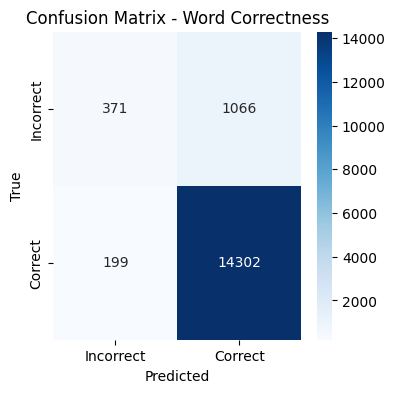


Utterance-Level Metrics:
                MAE    MSE     R²    PCC
accuracy      0.078  0.011  0.522  0.734
fluency       0.072  0.009  0.559  0.776
completeness  0.008  0.003  0.015  0.213
prosody       0.078  0.010  0.515  0.760
overall       0.092  0.014  0.415  0.755


In [ ]:
# @title VALIDATION
# Required imports (subset of your original imports)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report, confusion_matrix
from scipy.stats import pearsonr

def evaluate_and_visualize(all_preds, all_labels):
    print("=== Evaluation ===")
    word_true_list = []
    word_pred_list = []
    for pred_batch, label_batch in zip(all_preds, all_labels):
        word_true_list.extend(label_batch['word_scores'].flatten().tolist())
        word_pred_list.extend(pred_batch['word_scores'].flatten().tolist())

    # Word-level regression metrics
    y_true = np.array(word_true_list)
    y_pred = np.array(word_pred_list)
    valid_idx = y_true != 0  # Exclude padded values
    y_true = y_true[valid_idx]
    y_pred = y_pred[valid_idx]

    print("\nWord-Level Regression Metrics:")
    if len(y_true) > 0:
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        pcc, _ = pearsonr(y_true, y_pred) if len(y_true) > 1 else (0.0, 0.0)
        print(f"MAE: {mae:.3f}")
        print(f"MSE: {mse:.3f}")
        print(f"R²: {r2:.3f}")
        print(f"PCC: {pcc:.3f}")

    # Word-level classification metrics
    print("\nWord-Level Classification Metrics (Threshold = 0.7):")
    y_true_binary = (y_true >= 0.7).astype(int)  # 0: incorrect (<0.7), 1: correct (≥0.7)
    y_pred_binary = (y_pred >= 0.7).astype(int)
    print(classification_report(y_true_binary, y_pred_binary, digits=3, target_names=["Incorrect", "Correct"]))

    # Confusion matrix
    cm = confusion_matrix(y_true_binary, y_pred_binary)
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["Incorrect", "Correct"],
                yticklabels=["Incorrect", "Correct"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix - Word Correctness")
    plt.show()

    # Utterance-level metrics (unchanged)
    utterance_metrics = {}
    aspects = ["accuracy", "fluency", "completeness", "prosody", "overall"]
    for idx, aspect in enumerate(aspects):
        y_true_u = np.concatenate([batch[aspect] for batch in all_labels])
        y_pred_u = np.concatenate([batch['utterance'][:, idx] for batch in all_preds])
        mae = mean_absolute_error(y_true_u, y_pred_u)
        mse = mean_squared_error(y_true_u, y_pred_u)
        r2 = r2_score(y_true_u, y_pred_u)
        pcc, _ = pearsonr(y_true_u, y_pred_u) if len(y_true_u) > 1 else (0.0, 0.0)
        utterance_metrics[aspect] = {"MAE": mae, "MSE": mse, "R²": r2, "PCC": pcc}

    df_metrics = pd.DataFrame(utterance_metrics).T
    print("\nUtterance-Level Metrics:")
    print(df_metrics.round(3))
if __name__ == "__main__":
    train_path = os.path.join(Config.PREPROCESS_DIR, "train_data.pt")
    test_path = os.path.join(Config.PREPROCESS_DIR, "test_data.pt")
    text_train_path = os.path.join(Config.DATA_DIR, "train", "text")
    text_test_path = os.path.join(Config.DATA_DIR, "test", "text")
    checkpoint_path = os.path.join(Config.PREPROCESS_DIR, "best_model_ever_create.pt")
    # all_preds, all_labels, utt_ids, all_words = run_inference(checkpoint_path, test_path, text_test_path)
    # display_inference_results(all_preds, all_labels, utt_ids, all_words, num_samples=5)
    evaluate_and_visualize(all_preds, all_labels)